In [1]:
import os
from hashlib import sha256
import pickle
from pathlib import Path
import json
from datetime import datetime

import pandas as pd
import numpy as np
from natsort import natsorted
import seaborn as sns

In [2]:
# open examples
data_path = '/home/jose/drive/data/lared_laughter/laughter_data'
laughter_examples_df = pd.read_csv(os.path.join(data_path, 'laughter_examples', 'examples.csv'), index_col=0)
speech_examples_df = pd.read_csv(os.path.join(data_path, 'speech_examples', 'examples.csv'), index_col=0)
calibration_examples_df = pd.read_csv(os.path.join(data_path, 'calibration_examples.csv'))

In [3]:
laughter_examples_df.sort_values('hash').head()

,id,pid,cam,valid,hash,_ini_time,_end_time,ini_time,end_time,labels,rect,ini,len
635,NaN,9,2,True,002043005fa746f076c845dc38dd1bd97327bde09e17fc...,7960.602390,7968.533860,7963.610,7965.490,"{'vad': None, 'label': None, 'vad_seg': None}","[676, 667, 196, 226]",NaN,NaN
1343,NaN,24,1,True,002983a2032f00517ba8aeada1d6b0522a43c09bc124f9...,5217.841801,5222.580123,5220.071,5220.754,"{'vad': None, 'label': None, 'vad_seg': None}",[],NaN,NaN
1581,NaN,30,4,True,006f74addfc99845bf6c9f80d13d52ccc1893410315255...,8287.730008,8295.177193,8289.657,8292.107,"{'vad': None, 'label': None, 'vad_seg': None}","[1221, 637, 145, 240]",NaN,NaN
1136,NaN,22,1,True,0070b1ba6e8de828aea5c6d3b9d1c3662959fb5f032a67...,1994.302349,2002.112154,1996.955,2000.122,"{'vad': None, 'label': None, 'vad_seg': None}","[1038, 262, 93, 164]",NaN,NaN
1498,NaN,29,2,True,008e79e8bca8779e990309572178eb7328f910a423b2b2...,3437.689973,3444.153003,3439.252,3440.802,"{'vad': None, 'label': None, 'vad_seg': None}",[],NaN,NaN


In [4]:
calibration_examples_df.head()

,Unnamed: 0,id,pid,cam,valid,hash,_ini_time,_end_time,ini_time,end_time,labels,rect,ini,len
0,0,NaN,1,2,True,64a92aea9395ace7ac9d60eab34911e419fc66610cd76f...,5740.496295,5746.537465,5740.496295,5746.537465,"{'vad': None, 'label': None, 'vad_seg': None}","[876, 19, 113, 110]",NaN,NaN
1,1,NaN,7,1,True,85aac70ec91eb3be1b313b33e0b7828394bbe4e4edc6a9...,5785.108463,5790.477508,5785.108463,5790.477508,"{'vad': None, 'label': None, 'vad_seg': None}","[257, 688, 257, 375]",NaN,NaN
2,2,NaN,7,1,True,b438e94f7fdcc80ea7927e320946c7b407b7c850fe04ba...,7978.613765,7985.929401,7978.613765,7985.929401,"{'vad': None, 'label': None, 'vad_seg': None}","[1026, 2, 113, 147]",NaN,NaN
3,3,NaN,21,1,True,68d229cf19eec82f37580265ea93892117dd5b559b04d2...,1749.826048,1756.912298,1749.826048,1756.912298,"{'vad': None, 'label': None, 'vad_seg': None}","[143, 684, 236, 319]",NaN,NaN
4,4,NaN,25,1,True,bb6337eea970487ce9cd4ff26ea78c7acc6d5d1a355b7a...,4478.918347,4485.829214,4478.918347,4485.829214,"{'vad': None, 'label': None, 'vad_seg': None}","[1331, 130, 116, 167]",NaN,NaN


In [5]:
laughter_examples_df['onset_time']     = laughter_examples_df['ini_time'] - laughter_examples_df['_ini_time']
laughter_examples_df['offset_time']    = laughter_examples_df['_end_time'] - laughter_examples_df['ini_time']
speech_examples_df['onset_time']       = speech_examples_df['ini_time'] - speech_examples_df['_ini_time']
speech_examples_df['offset_time']      = speech_examples_df['_end_time'] - speech_examples_df['ini_time']
calibration_examples_df['onset_time']  = calibration_examples_df['ini_time'] - calibration_examples_df['_ini_time']
calibration_examples_df['offset_time'] = calibration_examples_df['_end_time'] - calibration_examples_df['ini_time']

In [6]:
laughter_examples = {row['hash']: row.to_dict() for _, row in laughter_examples_df.iterrows()}
speech_examples = {row['hash']: row.to_dict() for _, row in speech_examples_df.iterrows()}
calibration_examples = {row['hash']: row.to_dict() for _, row in calibration_examples_df.iterrows()}

In [7]:
len(laughter_examples), len(speech_examples), len(calibration_examples)

(1684, 444, 6)

In [8]:
# open results
results_path = os.path.join(data_path, 'results')
p = Path(results_path)

In [9]:
all_results = []
hit_info = []
for i_dir, dir in enumerate(p.iterdir()):
    hit_id = os.path.basename(dir)
    results_dict = {}
    continuous_annotations = {}

    num_segments = 0

    # process the hit info
    hitfiles = list(dir.glob('*.json'))
    hitfiles = [str(e) for e in hitfiles]
    hitfiles = natsorted(hitfiles)
    start_datetime = datetime.fromisoformat(json.load(open(hitfiles[0]))['submitted_at'])
    end_datetime = datetime.fromisoformat(json.load(open(hitfiles[-1]))['submitted_at'])
    duration = (end_datetime - start_datetime).seconds / 60

    assert 'Feedback' in str(hitfiles[-1]), f'Feedback not in {str(hitfiles[-1])}'
    feedback = json.load(open(hitfiles[-1]))

    hit_info.append({
        'duration': duration,
        'rating': feedback['response']['rating'],
        'feedback': feedback['response']['feedback']
    })

    # read the JSON (rating) files
    for i_file, json_file in enumerate(dir.glob('*.json')):
        # get example index
        
        fname = os.path.basename(json_file).split('.')[0]
        if 'example' in fname or 'rating' not in fname:
            continue

        # {index}_{recognition|rating}_{hash}_{condition}_{block}_{1 if calibration else 0}'
        # 14_rating_47d49b6e15d4befe8e7a9508068046a7d5478da30f1cc77074951c94cdef9439_video_1_0_0
        parts = fname.split('_')

        index_in_hit = int(parts[0])
        example_hash = parts[2]
        condition = parts[3]
        block = int(parts[4])
        calibration = (parts[5] == '1')

        # read the json response
        json_res = json.load(open(json_file))['response']
        if json_res is None:
            json_res = {}
            print(f'json_res is None for file {json_file}')

        # get the ground truth
        if example_hash in laughter_examples:
            example = laughter_examples[example_hash]
            gt_laughter = True
        elif example_hash in calibration_examples:
            example = calibration_examples[example_hash]
            gt_laughter = True
        elif example_hash in speech_examples:
            example = speech_examples[example_hash]
            gt_laughter = False
        else:
            raise Exception(f'example hash {example_hash} not found anywhere for {i_dir}, {i_file}, {fname}')

        results_dict[example_hash] = {
            'person': example['pid'], 
            'cam': example['cam'],
            'hit_id': hit_id, 
            'condition': condition,
            'calibration': calibration,
            'hash': example_hash,
            'ini_time': example['ini_time'],
            'end_time': example['end_time'],
            '_ini_time': example['_ini_time'],
            '_end_time': example['_end_time'],
            'gt_onset': example['onset_time'],
            'gt_offset': example['offset_time'],
            'gt_laughter': gt_laughter,
            'is_laughter': json_res.get('laughter', True),
            'confidence': json_res.get('confidence', 4),
            'intensity': json_res.get('intensity', 4)
        }
        num_segments += 1

    # read the CSV (continuous) files

    csv_files = [f for f in dir.glob('*.csv')]
    for csv_file in sorted(csv_files):
        fname = os.path.basename(csv_file).split('.')[0]
        if 'example' in fname or 'recognition' not in fname:
            continue
        parts = fname.split('_')
        attempt = int(parts[-1])
        example_hash = parts[2]

        cont_data = pd.read_csv(csv_file, index_col=0, header=0)
        pressed_key = cont_data['data0'].any()

        results_dict[example_hash] = {
            **results_dict[example_hash],
            'attempt': attempt,
            'pressed_key': pressed_key,
            'onset': cont_data[cont_data['data0'] == 1].iloc[0]['media_time'] if pressed_key else None,
            'offset': cont_data[cont_data['data0'] == 1].iloc[-1]['media_time'] if pressed_key else None
        }

        continuous_annotations[example_hash] = cont_data[['media_time', 'data0']]

    all_results.append({'hit':hit_id ,'processed': results_dict, 'continuous': continuous_annotations})
    print(f'HIT {hit_id}, segments: {num_segments}')

HIT 9c45e4f0c5442e796eb93e73e94dc6c2dfca7b9c4c54ff9314ab0956fc1f454a, segments: 90
HIT 3043daaa2251d5bb838d07f549ac19b7d41fb1880bca6ab36da5bb0920851459, segments: 90
HIT e05f2a5388f6a3d5fc326863222f3cc66bcdf7681ec73cdcd0159093bac7a0e3, segments: 90
HIT 694a4fa5b2a7733614c89f9c82605b95a39706c5f91a510d635dec64e994e19c, segments: 90
HIT 47d05370e41ca3944898561425eb80a67ee2dbc340a69b1bf7fffc5a8a1d461c, segments: 90
HIT d53d0dfa8d0670c4af862bbc7ada03ef55a15f146a03b31a2f26c9f472347e3c, segments: 90
json_res is None for file /home/jose/drive/data/lared_laughter/laughter_data/results/4198c11729cea33268040a725998f16478a6564d4af091b2d40b84d727e35aaa/111_rating_0219ab2467ec6269e71c5445002aaece1e03a2ea4f65aedf1f4da0a75aeffbcb_video_1_0_0.json
HIT 4198c11729cea33268040a725998f16478a6564d4af091b2d40b84d727e35aaa, segments: 90
HIT 99cd9c6d87f8785f6ee01ff22ea0245811dff0968a9b125759a5acf9531260c3, segments: 90
HIT bf09e23008d5f42070cbea6f5d28d4e40fac65d263f510d1552bf46e26146814, segments: 90
HIT 81738e

In [10]:
results = []
annotations = []
for res in all_results:
    for key in res['processed'].keys():
        if not key in res['continuous']:
            print(f'Continuous annotation not found for HIT {res["hit"]} example {key}')
            continue
        results.append(res['processed'][key])
        annotations.append(res['continuous'][key])

Continuous annotation not found for HIT 47d05370e41ca3944898561425eb80a67ee2dbc340a69b1bf7fffc5a8a1d461c example 34fda341d0310d4faef4731256cddff498a2d5b5b02851ca79fbff28208a81a9
Continuous annotation not found for HIT 47d05370e41ca3944898561425eb80a67ee2dbc340a69b1bf7fffc5a8a1d461c example aec5c4c6ee20742e845612304ab8523eb32c7b8c00fa04692e6493153ed2af14
Continuous annotation not found for HIT 47d05370e41ca3944898561425eb80a67ee2dbc340a69b1bf7fffc5a8a1d461c example f853082655fb5bc91619f5fc17e93f16379bb02aa764b222d5e704c3747faf9b
Continuous annotation not found for HIT 47d05370e41ca3944898561425eb80a67ee2dbc340a69b1bf7fffc5a8a1d461c example 0bc9e6a4b6ea69f087559862cfb6e92c6c46aa71a3d4ec6f1d5b6126126b6b64
Continuous annotation not found for HIT 47d05370e41ca3944898561425eb80a67ee2dbc340a69b1bf7fffc5a8a1d461c example df60125e135d213fbcebf95e28113b40594fedbb804343cb845345bf5a526ecb
Continuous annotation not found for HIT 47d05370e41ca3944898561425eb80a67ee2dbc340a69b1bf7fffc5a8a1d461c examp

In [16]:
results = pd.DataFrame.from_dict(results)
# create a new hash column containing a rating-specific hash
# calculated from the combination of hit and example hash
results['rating_hash'] = results.apply(lambda x: sha256((x['hit_id'] + x['hash']).encode()).hexdigest(), axis=1)

In [18]:
len(results)

3043

In [19]:
results[results['hash'] == '12b5c620b18a8354b1c2368935c52d9507c1144e7af2511226bbb1447398ee0c']

,person,cam,hit_id,condition,calibration,hash,ini_time,end_time,_ini_time,_end_time,...,gt_offset,gt_laughter,is_laughter,confidence,intensity,attempt,pressed_key,onset,offset,rating_hash
183,23,4,e05f2a5388f6a3d5fc326863222f3cc66bcdf7681ec73c...,video,False,12b5c620b18a8354b1c2368935c52d9507c1144e7af251...,4779.146,4779.912,4776.017928,4782.354826,...,3.208826,True,False,7,4,0,False,NaN,NaN,d32f078893b796cfeeb49d4d83c99ceef0620f9c7fcdde...
740,23,4,bf09e23008d5f42070cbea6f5d28d4e40fac65d263f510...,audio,False,12b5c620b18a8354b1c2368935c52d9507c1144e7af251...,4779.146,4779.912,4776.017928,4782.354826,...,3.208826,True,True,5,1,0,True,4.143220,4.303220,e87b20a7300c63c0daf2e7286e617d40e3d2b8f62f7c17...
856,23,4,81738e72addf1d736f6a09a38e1681b008dec5b88a09fd...,av,False,12b5c620b18a8354b1c2368935c52d9507c1144e7af251...,4779.146,4779.912,4776.017928,4782.354826,...,3.208826,True,True,6,2,0,True,4.227424,4.894758,f3dcc6a393a5f0c91efdcc026145b246551ef4b84e5c55...
1330,23,4,e55b516e948235882898c3406920bf2e05eeaa9d8d4874...,audio,False,12b5c620b18a8354b1c2368935c52d9507c1144e7af251...,4779.146,4779.912,4776.017928,4782.354826,...,3.208826,True,True,5,2,0,True,4.663220,5.143220,262a1829c139b8a60a25df0dfbc41e66d92edb2932e3e1...
2225,23,4,ac2e2173ac829b4f5442a1cfbae59ddb033fb8c04c4c06...,video,False,12b5c620b18a8354b1c2368935c52d9507c1144e7af251...,4779.146,4779.912,4776.017928,4782.354826,...,3.208826,True,True,2,2,0,True,5.338672,6.272940,cda49e492c28ef670d496d9e732d466dbf6ce0e2b83694...


## Camera correction
Correct for the lack of sync of one of the cameras

In [14]:


results.to_csv('./annotation_results.csv')
pickle.dump(annotations, open('./annotation_results_continuous.pkl', 'wb'))

In [15]:
results = pd.read_csv('./annotation_results.csv')

In [17]:
len(results)

3043

# Intensity distribution

<AxesSubplot:xlabel='intensity', ylabel='Count'>

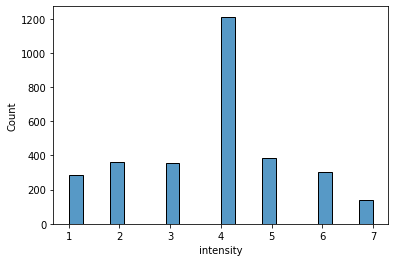

In [14]:
sns.histplot(results['intensity'])

# HIT information

In [21]:
pd.set_option('display.max_colwidth', 150)
pd.DataFrame(hit_info)

,duration,rating,feedback
0,50.016667,5.0,"The study was great because laughter is contagious - it was mood improving :) But some videos, maybe 3 of them, were not of good quality (there wa..."
1,47.800000,4.0,"a bit too long, instructions were good but a bit unclear when rating your confidence"
2,67.250000,5.0,Instructions were very much clear. Had no problems at all
3,45.116667,5.0,yes instructions were clear and it was intresting for me
4,51.316667,4.0,It was so much fun because you can notice body language and even difference in language and laughter. One thing I did have trouble with was the la...
5,36.516667,5.0,it was not too long nor tiring. the instructions were crystal clear and honestly it was kind of entertaining. some laughters were amazing!
6,51.016667,4.0,None
7,55.516667,5.0,The experiment was interesting and fun overall. The process was easy and the bar on the left side helped me see the progress I was making. \n\nIt ...
8,68.300000,5.0,"Maybe a little too long, but it was an interesting experience."
9,72.966667,5.0,The presentation of the study is clean and easy with instructions very clear. Videos that must be assessed is short. Given this it make the study ...
